In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
cmap = {'Vehicle': '#000000',
 'ABT-263': '#a9a9a9',
 'Venetoclax': '#a9a9a9',
 'Protac bcl2': '#f08080',
 'Protac bclxl': '#f08080'}

# Von Frey

In [3]:
von = pd.read_excel('../data/bh_format.xlsx')

In [4]:
von_long = von.melt(id_vars=['id','Drug','Side','aka'], value_vars=['baseline', 'CCI Day7', 'CCI Day16', 'CCI Day21', 'CCI Day28'], var_name='Time')
von_long.aka = von_long.aka.str.replace(' ', '')
von_long.aka = von_long.aka.astype('category').cat.reorder_categories(['Drug0','Drug1','Drug2','Drug3','Vehicle1','Vehicle2'])
von_long.Drug = von_long.Drug.apply(lambda x: 'Vehicle' if x.startswith('Vehicle') else x)
von_long.Drug = von_long.Drug.astype('category').cat.reorder_categories(['Vehicle','ABT-263','Venetoclax','P bcl2 deg1','P bcl2 deg2'])
von_long.Drug = von_long.Drug.astype('category').cat.rename_categories({'P bcl2 deg1':'Protac bcl2','P bcl2 deg2':'Protac bclxl'})

In [6]:
from statsmodels.stats.multitest import multipletests
ttest={}
for d in von_long.Drug.cat.categories:
    ttest[d] = []
    for s in von_long.Side.unique():
        st, p = stats.ttest_rel(von_long[(von_long.Drug == d) & (von_long.Side == s) & (von_long.Time == 'baseline')].value,
                                von_long[(von_long.Drug == d) & (von_long.Side == s) & (von_long.Time == 'CCI Day28')].value)
        ttest[d].append(p)
    ttest[d] = multipletests(ttest[d], alpha=0.05, method='bonferroni')[1]

In [7]:
# p-val of ipsi follows by contra
ttest

{'Vehicle': array([3.51144469e-09, 8.83929345e-02]),
 'ABT-263': array([0.78462445, 1.        ]),
 'Venetoclax': array([0.00324751, 0.29440658]),
 'Protac bcl2': array([0.61505788, 1.        ]),
 'Protac bclxl': array([0.02060454, 0.30169145])}

In [367]:
# define a function to calculate the min and max of the SEM
def cal_sem(x:np.array):
    return np.mean(x) - stats.sem(x, nan_policy='omit'), np.mean(x) + stats.sem(x, nan_policy='omit')

In [368]:
def stat_not(x):
    if x < 0.001:
        return '***'
    elif 0.001 < x < 0.05:
        return '*'
    else:
        return 'ns'

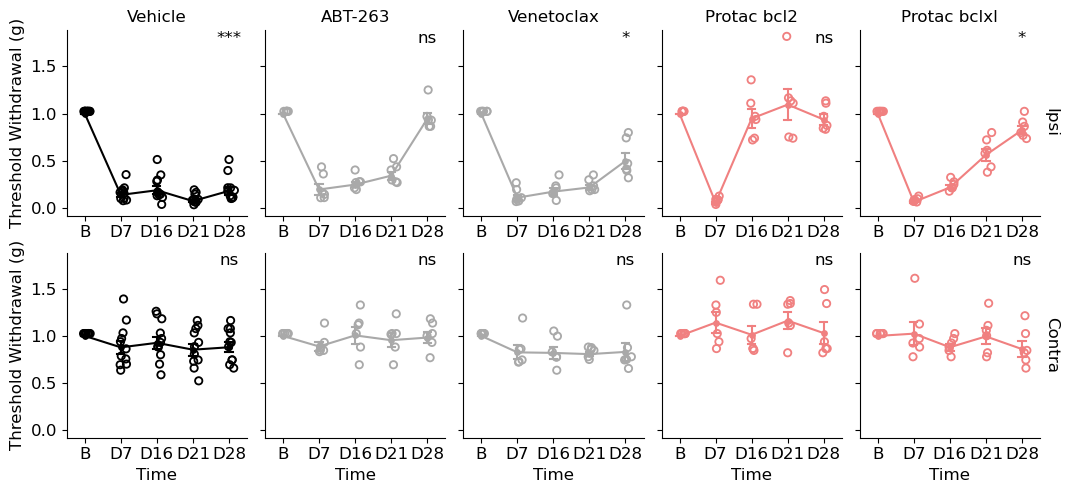

In [369]:
g = sns.catplot(x='Time', y='value', hue='Drug', data=von_long,
                errorbar=cal_sem, kind='point',capsize=.2, palette=cmap,
                height=2.5, linewidth=1.5, col="Drug", row='Side', aspect=0.9, margin_titles=True)
g.map_dataframe(sns.stripplot, x='Time', y='value', hue='Drug', palette=cmap, zorder=1, dodge=False, marker="$\circ$", edgecolor="face", s=10)
g.legend.set_visible(False)
g.set_xticklabels(['B','D7','D16','D21','D28'])
g.tick_params(labelsize=12)
g.set_xlabels('Time', fontsize=12)
g.set_ylabels('Threshold Withdrawal (g)', fontsize=12)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=12)
g.figure.subplots_adjust(hspace=0.2, wspace=0.1)
for i,v in enumerate(g.axes):
    k = [ax.get_title() for ax in g.axes[0]]
    for j,ax in enumerate(v):
        pval = ttest[k[j%5]][i]
        ax.text(4, 1.8, stat_not(pval), ha='center', va='center', fontsize=12)
        ax.tick_params(labelbottom=True)
        ax.set_title(ax.get_title())
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_von_long.pdf', bbox_inches='tight', dpi=300)

# Pinprick

In [3]:
pin = pd.read_excel('../data/bh_format.xlsx', sheet_name='pin')

In [401]:
pin_long = pin.melt(id_vars=['id','Drug','Side','aka','Conditions'], value_vars=['v1', 'v2', 'v3', 'v4'], var_name='Score')
pin_long.aka = pin_long.aka.str.replace(' ', '')
pin_long.aka = pin_long.aka.astype('category').cat.reorder_categories(['Drug0','Drug1','Drug2','Drug3','Vehicle1'])
pin_long.Drug = pin_long.Drug.astype('category').cat.reorder_categories(['ABT-263','Venetoclax','P bcl2 deg1','P bcl2 deg2','Vehicle1'])
pin_long.Drug = pin_long.Drug.astype('category').cat.rename_categories({'P bcl2 deg1':'Protac bcl2','P bcl2 deg2':'Protac bclxl', 'Vehicle1':'Vehicle'})
pin_long.Conditions = pin_long.Conditions.astype('category').cat.reorder_categories(['Baseline','CCI28'])

In [402]:
from statsmodels.stats.multitest import multipletests
ttest={}
for d in pin_long.Drug.cat.categories[1:]:
    ttest[d] = []
    for s in pin_long.Side.unique():
        st, p = stats.ttest_rel(pin_long[(pin_long.Drug == d) & (pin_long.Side == s) & (pin_long.Conditions == 'Baseline')].value,
                                pin_long[(pin_long.Drug == d) & (pin_long.Side == s) & (pin_long.Conditions == 'CCI28')].value,
                                nan_policy='omit')
        ttest[d].append(p)
    ttest[d] = multipletests(ttest[d], alpha=0.05, method='bonferroni')[1]

In [403]:
ttest_new = {'ABT-263':np.array([8.85185142e-05, 3.61529942e-06])}

In [404]:
ttest_new.update(ttest)

In [405]:
pin_long.Drug = pin_long.Drug.astype('category').cat.reorder_categories(['Vehicle','ABT-263','Venetoclax','Protac bcl2','Protac bclxl'])

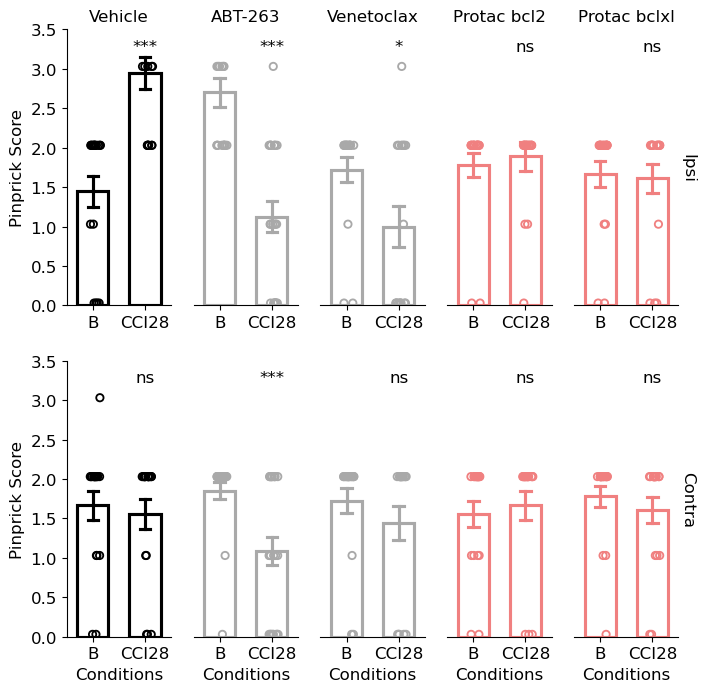

In [409]:
g = sns.catplot(x='Conditions', y='value', hue='Drug', data=pin_long,
                dodge=False, palette=cmap, fill=False, width=0.6,
                kind='bar',errorbar=cal_sem, capsize=.2,
                row='Side', col='Drug',height=3.5, aspect=0.425, facet_kws=dict(ylim=(0,3.5)), margin_titles=True)
g.map_dataframe(sns.stripplot, x='Conditions', y='value', hue='Drug',
                palette=cmap, zorder=1, marker="$\circ$", s=10)
g.legend.set_visible(False)
g.set_xlabels('Conditions', fontsize=12)
g.set_ylabels('Pinprick Score', fontsize=12)
g.tick_params(labelsize=12)
g.set_xticklabels(['B','CCI28'])
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=12)
g.figure.subplots_adjust(hspace=0.2)
for i,v in enumerate(g.axes):
    k = [ax.get_title() for ax in g.axes[0]]
    for j,ax in enumerate(v):
        if j not in [0,5]:
            ax.spines['left'].set_visible(False)
            ax.tick_params(left=False)
        pval = ttest_new[k[j%5]][i]
        ax.text(1, 3.28, stat_not(pval), ha='center', va='center', fontsize=12)
        ax.tick_params(labelbottom=True)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_pin_long.pdf', bbox_inches='tight', dpi=300)